# Proc33ssor Prototype

# Proc33ssor Prototype

## Overview

**Proc33ssor** is a standalone application designed to analyze and catalog a large archive of images on a local machine. This prototype focuses on processing a single image to generate detailed metadata and then extending the process to handle multiple images. The metadata will be stored in a local database, enabling efficient searching and retrieval of images based on various criteria.

## Features

1. **Image Tagging:**
   - Generate descriptive tags for images using a locally hosted Large Language Model (LLM).
   - **Technologies:** Hugging Face Transformers, spaCy

2. **Basic Data Analysis:**
   - Analyze and display metrics such as value distribution, color scheme, and color gamut.
     - [x] Read Image Metadata
     - [x] Grayscale Value Distribution: Histogram of pixel values, after image has been converted to BW.
     - [x] 2 Value Posterize Value Distribution: Histogram of pixel values, after image has been converted to 2 colors.
     - [ ] Full Color Distribution: Histogram of color values.
     - [ ] Image Proportion: Aspect ratio of the image.
   - Additional metrics: edge detection, texture analysis, and histogram analysis.
   - **Technologies:** OpenCV, scikit-image

3. **Unique Identifier Embedding:**
   - Embed a unique identifier into the byte data of each image to record authorship and identity.
   - **Technologies:** Pillow, Steganography Libraries (e.g., Stegano)

4. **Additional Metrics:**
   - Detect dominant colors and objects in images.
   - **Technologies:** TensorFlow/Keras, EXIFRead

5. **Database Storage:**
   - Store and retrieve image metadata and version history in a local database.
   - **Technologies:** SQLite

6. **Natural Language Search:**
   - Implement basic search functionality to find images based on written prompts.
   - **Technologies:** Elasticsearch

7. **Version Control:**
   - Maintain a `proc33ssVersion` value embedded in each image and store version history in the database.
   - Track and store the current version in an environment variable on the host system.


## 0. Setup

In [31]:
image_path = "./images/exampleImage.png"

## 2. Pixel Data Analysis

### 2.1 Read Image Metadata

In [32]:
# pip install exifread
import exifread
from PIL import Image
import re
from pprint import pprint

# ⭐️ Extracting metadata from images and cleaning it ⭐️
def read_metadata(image_path):
    # Using Pillow to read basic metadata
    image = Image.open(image_path)
    pillow_metadata = image.info
    
    # Using exifread to read EXIF metadata
    with open(image_path, 'rb') as img_file:
        exif_metadata = exifread.process_file(img_file)
    
    # Combine both metadata into a single dictionary
    combined_metadata = {
        "pillow_metadata": pillow_metadata,
        "exif_metadata": {tag: str(exif_metadata[tag]) for tag in exif_metadata.keys()}
    }
    
    return combined_metadata

def extract_parameters(description):
    # Regular expression to find parameters like --param value
    pattern = re.compile(r'--(\w+)\s+([\w:]+)')
    matches = pattern.findall(description)
    
    params = {key: value for key, value in matches}
    return params

def extract_job_id(description):
    # Regular expression to find Job ID
    pattern = re.compile(r'Job ID:\s+([\w-]+)')
    match = pattern.search(description)
    
    if match:
        return match.group(1)
    return None

def clean_metadata(metadata):
    # Extract relevant information
    cleaned_metadata = {
        key: metadata['pillow_metadata'][key] for key in metadata['pillow_metadata']
        if key in ['Creation Time', 'Author', 'Description']
    }
    
    # Extract parameters from description if available
    if 'Description' in cleaned_metadata:
        description = cleaned_metadata['Description']
        
        # Extract parameters
        params = extract_parameters(description)
        cleaned_metadata.update(params)
        
        # Extract Job ID
        job_id = extract_job_id(description)
        if job_id:
            cleaned_metadata['Job ID'] = job_id
        
        # Remove the parameters and Job ID from the description
        cleaned_metadata['Description'] = re.sub(r'--\w+\s+[\w:]+', '', description)
        cleaned_metadata['Description'] = re.sub(r'Job ID:\s+[\w-]+', '', cleaned_metadata['Description']).strip()
    
    return cleaned_metadata

# Example usage
metadata = read_metadata(image_path)

# Clean the metadata
cleaned_metadata = clean_metadata(metadata)

# Print cleaned metadata
pprint(cleaned_metadata)

PNG file does not have exif data.


{'Author': 'thirty.thr3',
 'Creation Time': 'Sun, 02 Jun 2024 11:25:47 GMT',
 'Description': 'cowboy knight templar + in Babylonian New Mexico, circa year '
                '1888, in the style of afro-fantasy hollywood fantasy + 16k '
                'UE5 graphics + CGI cinematic movie screenshot',
 'Job ID': '9f5c7ef9-b731-440d-b3f8-82221e1630e2',
 'ar': '1:1',
 'chaos': '15'}


### 2.2 Value Distribution Analysis

### Introduction

In image processing, analyzing the pixel value distribution is a fundamental task that helps in understanding the intensity variation across an image. The pixel value distribution, also known as the histogram of pixel intensities, provides insights into the contrast, brightness, and intensity range of the image. This metric is particularly useful for applications such as image enhancement, thresholding, and image segmentation.

### What is Value Distribution?

The value distribution of an image refers to the frequency of occurrence of each pixel intensity value within the image. For a grayscale image, the pixel values range from 0 (black) to 255 (white). By examining how often each of these values occurs, we can gather valuable information about the image's overall appearance and characteristics.

### Data Structure

The output of the value distribution analysis is a dictionary where the keys represent the pixel intensity values (ranging from 0 to 255), and the values represent the frequency of each pixel intensity within the image. This data structure is not only easy to interpret but also convenient for storage in a database for future reference and analysis.

### Example

Consider a simple grayscale image with the following pixel values:

```
[[  0, 255, 128],
 [128, 128,  64],
 [255,   0,  64]]
```

The value distribution for this image would be:

```
{
  0: 2,
  64: 2,
  128: 3,
  255: 2
}
```

In this example, the pixel intensity value `0` appears twice, `64` appears twice, `128` appears three times, and `255` appears twice. This histogram-like representation provides a clear view of how pixel values are distributed across the image.

### Visualization

To enhance understanding, we can visualize the value distribution as a bar chart. The x-axis represents the pixel intensity values, and the y-axis represents the frequency of each value. This visual representation helps in quickly identifying patterns such as whether the image is predominantly dark, bright, or has a good contrast.

### Implementation

Calculate and visualize the value distribution of a grayscale image:

1. **Load and display the image:**
   - Use OpenCV to load the image in grayscale mode.
   - Display the image using matplotlib.

2. **Calculate the value distribution:**
   - Flatten the image array to a one-dimensional list of pixel values.
   - Use the `Counter` class from the `collections` module to count the frequency of each pixel value.
   - Convert the `Counter` object to a dictionary for easy storage and retrieval.

3. **Visualize the value distribution:**
   - Prepare the data for plotting.
   - Use matplotlib to create a bar chart representing the pixel value distribution.

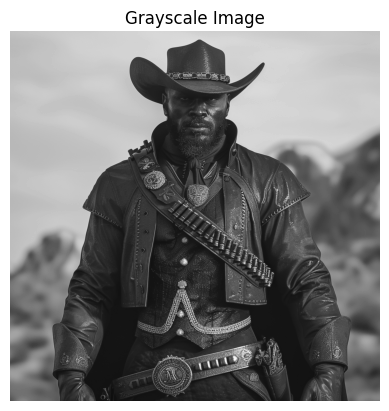

In [33]:
# pip install opencv-python matplotlib numpy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale

# Display the image
plt.imshow(image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

In [34]:
# ⭐️ Calculate the value distribution of the image ⭐️
from pprint import pprint

def calculate_value_distribution(image):
    # Flatten the image array and calculate the frequency of each pixel value
    flat_image = image.flatten()
    value_counts = Counter(flat_image)
    
    # Convert the Counter object to a dictionary for easy future storage
    value_distribution = dict(value_counts)
    
    return value_distribution

# Calculate the value distribution
value_distribution = calculate_value_distribution(image)

# Print the value distribution (for checking the output)
pprint(value_distribution)

{0: 61,
 1: 15,
 2: 28,
 3: 18,
 4: 28,
 5: 24,
 6: 31,
 7: 31,
 8: 42,
 9: 37,
 10: 60,
 11: 94,
 12: 64,
 13: 116,
 14: 193,
 15: 294,
 16: 518,
 17: 1030,
 18: 3136,
 19: 14156,
 20: 25342,
 21: 15846,
 22: 8480,
 23: 8357,
 24: 8636,
 25: 8261,
 26: 8093,
 27: 8504,
 28: 8633,
 29: 9157,
 30: 9177,
 31: 8675,
 32: 8074,
 33: 7727,
 34: 7855,
 35: 7654,
 36: 7880,
 37: 7900,
 38: 8054,
 39: 7734,
 40: 7645,
 41: 7659,
 42: 7699,
 43: 7667,
 44: 7865,
 45: 7543,
 46: 7758,
 47: 8040,
 48: 7819,
 49: 8005,
 50: 8067,
 51: 7912,
 52: 7757,
 53: 7616,
 54: 7558,
 55: 7391,
 56: 7236,
 57: 7343,
 58: 7340,
 59: 6764,
 60: 6577,
 61: 6345,
 62: 6013,
 63: 5917,
 64: 5866,
 65: 5930,
 66: 5876,
 67: 5786,
 68: 5585,
 69: 5439,
 70: 5375,
 71: 5131,
 72: 5062,
 73: 4942,
 74: 4897,
 75: 4996,
 76: 5018,
 77: 4881,
 78: 5118,
 79: 5331,
 80: 5393,
 81: 5639,
 82: 5455,
 83: 5360,
 84: 5143,
 85: 4948,
 86: 4798,
 87: 4825,
 88: 4644,
 89: 4463,
 90: 4530,
 91: 4382,
 92: 4231,
 93: 4024,
 94

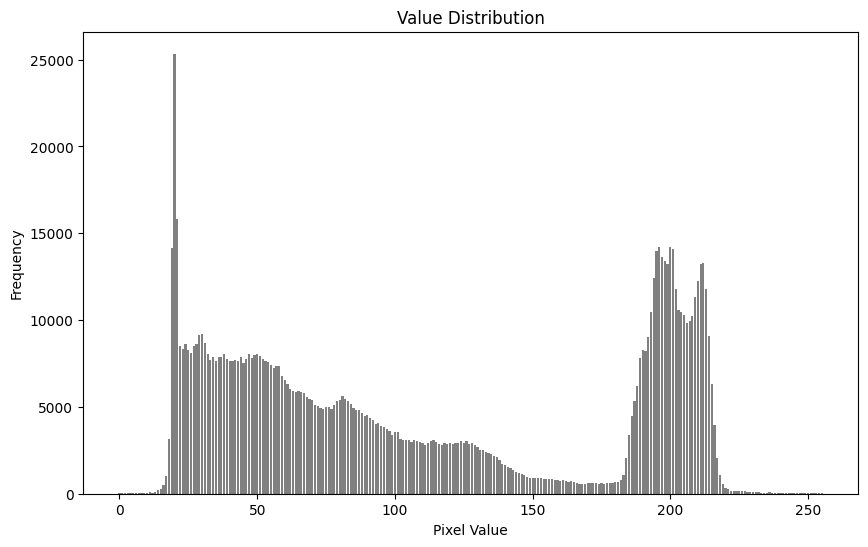

In [35]:
def plot_value_distribution(value_distribution):
    # Prepare data for plotting
    values = list(value_distribution.keys())
    counts = list(value_distribution.values())
    
    # Plot the value distribution
    plt.figure(figsize=(10, 6))
    plt.bar(values, counts, color='gray')
    plt.title('Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot the value distribution
plot_value_distribution(value_distribution)


## 2.3 Extreme Posterize Value Distribution Analysis

### Posterized Value Distribution: Histogram of Pixel Values (Two-Color Image)

#### Introduction

Posterizing an image is the process of reducing the number of distinct colors or shades in the image, which can simplify its visual appearance. In this section, we focus on converting an image to a two-color (black and white) version and analyzing its pixel value distribution. This simplified representation can be useful for various image processing tasks, including thresholding, segmentation, and feature extraction.

By converting the image to two colors, we reduce the complexity of the pixel values to just two possible states: 0 (black) and 255 (white). This binary representation allows us to easily analyze and visualize the distribution of these two pixel values. 

#### Steps:

1. **Convert Image to Grayscale**: First, we load the image and convert it to grayscale, reducing the image to shades of gray.
2. **Apply Threshold to Create a Two-Color Image**: Next, we apply a binary threshold to convert the grayscale image to a two-color image (black and white). This involves setting a threshold value such that all pixel values above the threshold are set to 255 (white), and all pixel values below the threshold are set to 0 (black).
3. **Calculate and Plot the Histogram of Pixel Values**: Finally, we calculate the frequency of the two pixel values (0 and 255) and plot the histogram to visualize their distribution.

This analysis provides a clear view of the image's composition in terms of black and white regions, which can be further used for more complex image processing tasks.

#### Explanation

1. **Loading and Displaying the Original Image**:
   - We load the image in grayscale mode using OpenCV.
   - The original grayscale image is displayed using matplotlib.

2. **Converting to Two-Color Image**:
   - A binary threshold is applied to the grayscale image, converting it to a two-color image (black and white).
   - The resulting two-color image is displayed.

3. **Calculating and Plotting the Value Distribution**:
   - The `calculate_value_distribution` function flattens the image array and counts the frequency of each pixel value (0 and 255).
   - The value distribution is pretty-printed for better readability.
   - The `plot_value_distribution` function creates a histogram of the pixel values, showing the frequency of black and white pixels in the image.


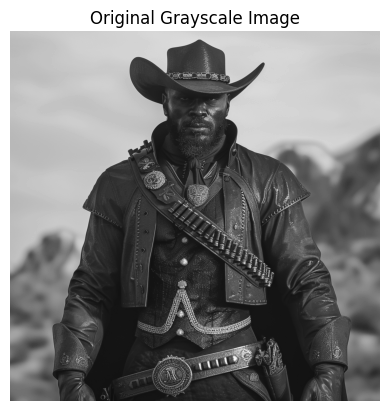

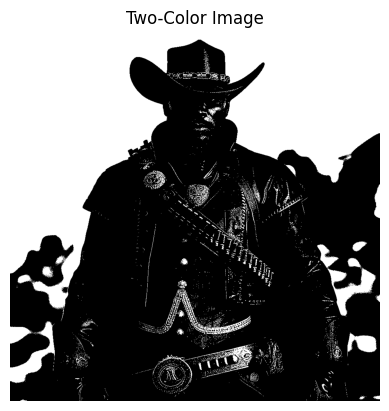

{0: 650532, 255: 398044}


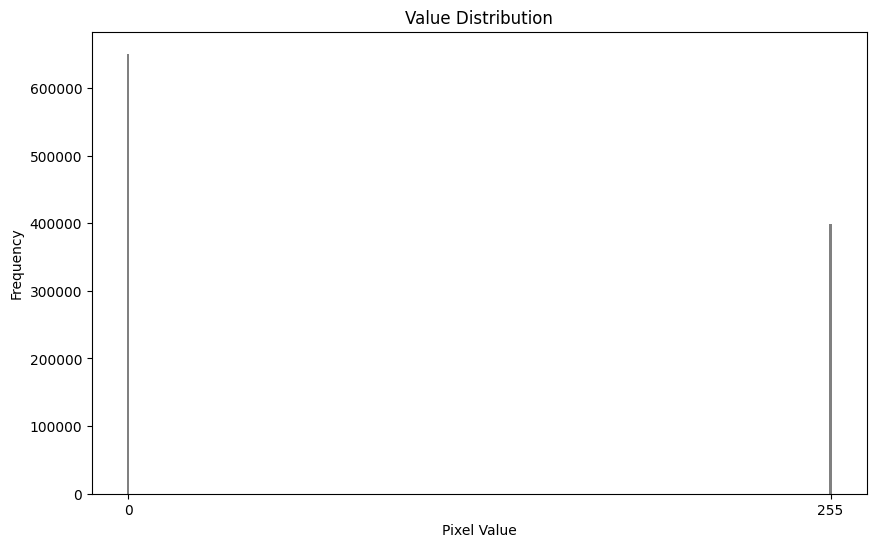

In [36]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pprint import pprint

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale

# Display the original grayscale image
plt.imshow(image, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')
plt.show()

# Apply a binary threshold to convert the image to two colors (black and white)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

# Display the two-color image
plt.imshow(binary_image, cmap='gray')
plt.title('Two-Color Image')
plt.axis('off')
plt.show()

# Function to calculate value distribution
def calculate_value_distribution(image):
    # Flatten the image array and calculate the frequency of each pixel value
    flat_image = image.flatten()
    value_counts = Counter(flat_image)
    
    # Convert the Counter object to a dictionary for easy future storage
    value_distribution = dict(value_counts)
    
    return value_distribution

# Function to plot value distribution
def plot_value_distribution(value_distribution):
    # Prepare data for plotting
    values = list(value_distribution.keys())
    counts = list(value_distribution.values())
    
    # Plot the value distribution
    plt.figure(figsize=(10, 6))
    plt.bar(values, counts, color='gray')
    plt.title('Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.xticks([0, 255])  # Only show 0 and 255 on the x-axis for two-color images
    plt.show()

# Calculate the value distribution for the two-color image
value_distribution = calculate_value_distribution(binary_image)

# Pretty print the value distribution
pprint(value_distribution)

# Plot the value distribution
plot_value_distribution(value_distribution)



## 2.4 CMYK Color Distribution: Histogram of Color Values

### Introduction

In this section, we will analyze the color distribution of an image by generating histograms for each color channel (Cyan, Magenta, Yellow, and Black). This analysis provides insights into the intensity distribution of each color channel and helps in understanding the overall color composition of the image. The histograms can be useful for various image processing tasks, such as color correction, enhancement, and segmentation.

### Steps:

1. **Load the Image in Color**: We will load the image using OpenCV in color mode.
2. **Convert the Image to CMYK**: We will convert the image from RGB to CMYK color space.
3. **Split the Image into CMYK Channels**: We will split the image into its Cyan, Magenta, Yellow, and Black channels.
4. **Calculate and Plot the Histogram for Each CMYK Channel**: We will calculate the frequency of intensity values for each color channel and plot the histograms.

### Explanation

1. **Loading and Displaying the Original Color Image**:
   - We load the image in color mode using OpenCV.
   - The original color image is displayed using matplotlib.

2. **Converting to CMYK**:
   - We convert the image from RGB to CMYK color space using a custom function `rgb_to_cmyk`.

3. **Splitting the Image into CMYK Channels**:
   - The image is split into its Cyan, Magenta, Yellow, and Black channels using `cv2.split`.

4. **Calculating and Plotting the Histogram for Each CMYK Channel**:
   - The `calculate_value_distribution` function flattens each color channel array and counts the frequency of each pixel value.
   - The value distributions for the Cyan, Magenta, Yellow, and Black channels are pretty-printed.
   - The `plot_value_distribution` function creates a histogram for each color channel, showing the frequency of intensity values.
   - We also create a combined histogram that overlays all the CMYK channels to visualize their overlapping distributions.

Cyan Channel Distribution:
{0: 328139,
 1: 7706,
 2: 6295,
 3: 6949,
 4: 4649,
 5: 5766,
 6: 7055,
 7: 9453,
 8: 8680,
 9: 7033,
 10: 6691,
 11: 9296,
 12: 13020,
 13: 10257,
 14: 11238,
 15: 10276,
 16: 19346,
 17: 16250,
 18: 12482,
 19: 12892,
 20: 15760,
 21: 21603,
 22: 32592,
 23: 28172,
 24: 21630,
 25: 15059,
 26: 15261,
 27: 17760,
 28: 16684,
 29: 19018,
 30: 17779,
 31: 14902,
 32: 12464,
 33: 12903,
 34: 12181,
 35: 10598,
 36: 12750,
 37: 12331,
 38: 11755,
 39: 12163,
 40: 11704,
 41: 8301,
 42: 6507,
 43: 5959,
 44: 5756,
 45: 4542,
 46: 5292,
 47: 5151,
 48: 4074,
 49: 6365,
 50: 7431,
 51: 1123,
 52: 4988,
 53: 4270,
 54: 5003,
 55: 4849,
 56: 4489,
 57: 4624,
 58: 4549,
 59: 4499,
 60: 2798,
 61: 5077,
 62: 3070,
 63: 6253,
 64: 1501,
 65: 3957,
 66: 3556,
 67: 4322,
 68: 2793,
 69: 3057,
 70: 3194,
 71: 3214,
 72: 3557,
 73: 1480,
 74: 3473,
 75: 2195,
 76: 2410,
 77: 2425,
 78: 2036,
 79: 2413,
 80: 2188,
 81: 1843,
 82: 2092,
 83: 1805,
 84: 3172,
 85: 10,
 86: 148

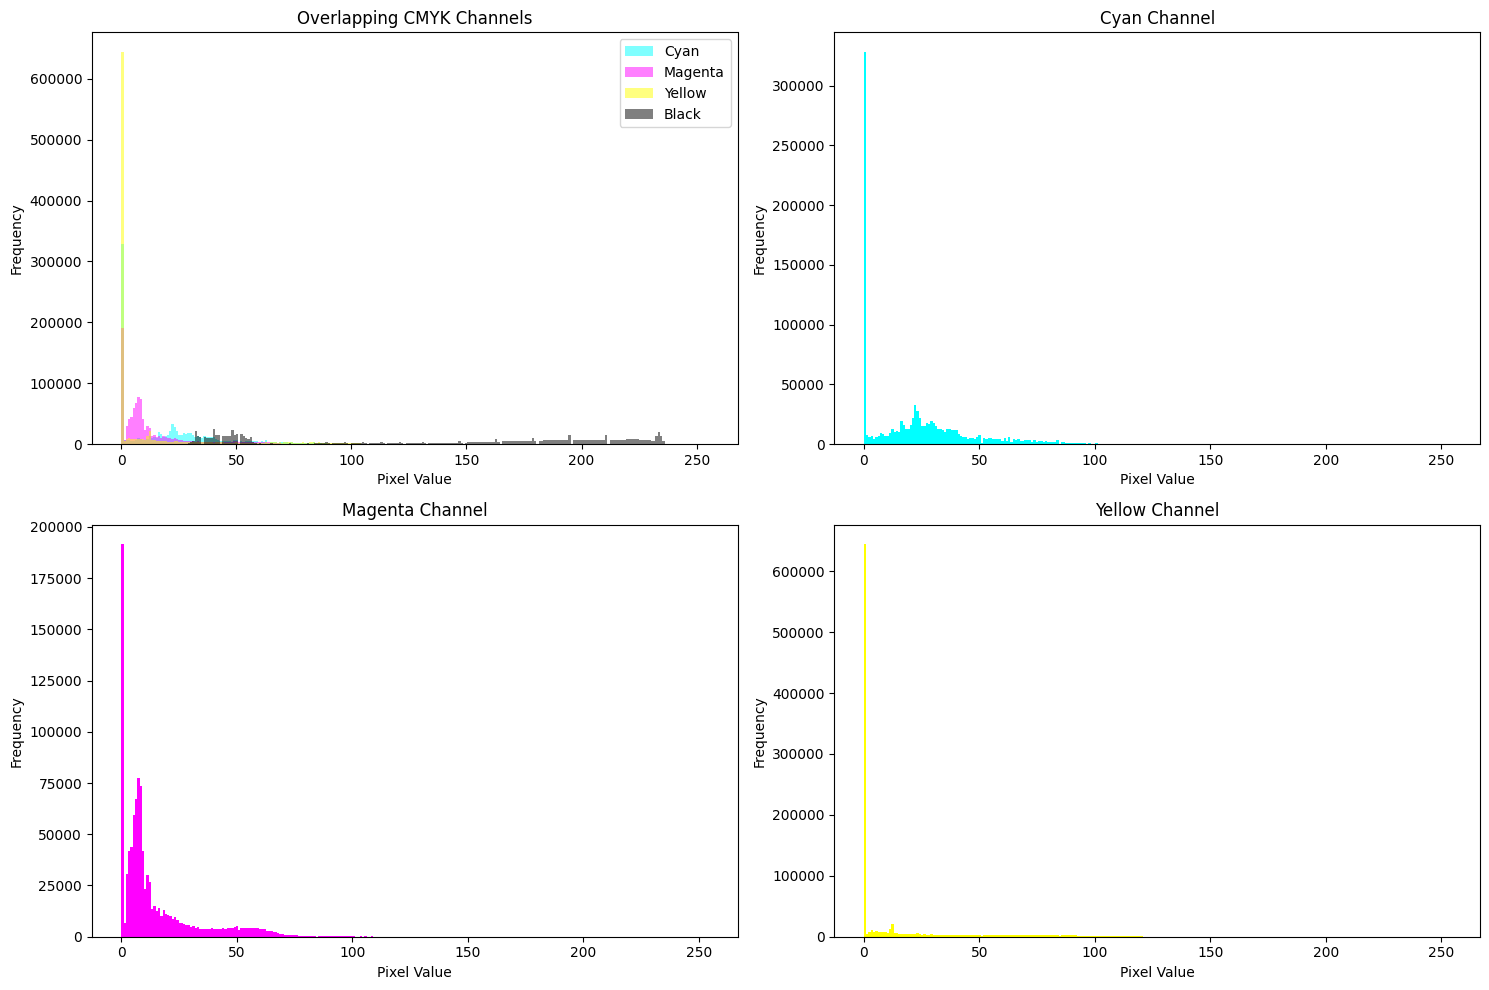

In [37]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pprint import pprint

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load image in color

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Function to convert RGB to CMYK
def rgb_to_cmyk(image):
    img = image.astype('float') / 255.0
    K = 1 - np.max(img, axis=2)
    C = (1 - img[..., 0] - K) / (1 - K + 1e-10)
    M = (1 - img[..., 1] - K) / (1 - K + 1e-10)
    Y = (1 - img[..., 2] - K) / (1 - K + 1e-10)
    CMYK = (np.dstack((C, M, Y, K)) * 255).astype('uint8')
    return CMYK

# Convert the image to CMYK
image_cmyk = rgb_to_cmyk(image_rgb)

# Split the image into CMYK channels
cyan_channel, magenta_channel, yellow_channel, black_channel = cv2.split(image_cmyk)

# Function to calculate value distribution
def calculate_value_distribution(channel):
    # Flatten the channel array and calculate the frequency of each pixel value
    flat_channel = channel.flatten()
    value_counts = Counter(flat_channel)
    
    # Convert the Counter object to a dictionary for easy future storage
    value_distribution = dict(value_counts)
    
    return value_distribution

# Calculate the value distribution for each CMYK channel
cyan_distribution = calculate_value_distribution(cyan_channel)
magenta_distribution = calculate_value_distribution(magenta_channel)
yellow_distribution = calculate_value_distribution(yellow_channel)
black_distribution = calculate_value_distribution(black_channel)

# Pretty print the value distribution
print("Cyan Channel Distribution:")
pprint(cyan_distribution)
print("\nMagenta Channel Distribution:")
pprint(magenta_distribution)
print("\nYellow Channel Distribution:")
pprint(yellow_distribution)
print("\nBlack Channel Distribution:")
pprint(black_distribution)

# Create the dashboard with 4 charts
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Overlapping all CMYK channels
axs[0, 0].hist(cyan_channel.flatten(), bins=256, color='cyan', alpha=0.5, label='Cyan')
axs[0, 0].hist(magenta_channel.flatten(), bins=256, color='magenta', alpha=0.5, label='Magenta')
axs[0, 0].hist(yellow_channel.flatten(), bins=256, color='yellow', alpha=0.5, label='Yellow')
axs[0, 0].hist(black_channel.flatten(), bins=256, color='black', alpha=0.5, label='Black')
axs[0, 0].set_title('Overlapping CMYK Channels')
axs[0, 0].set_xlabel('Pixel Value')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

# Cyan channel
axs[0, 1].hist(cyan_channel.flatten(), bins=256, color='cyan')
axs[0, 1].set_title('Cyan Channel')
axs[0, 1].set_xlabel('Pixel Value')
axs[0, 1].set_ylabel('Frequency')

# Magenta channel
axs[1, 0].hist(magenta_channel.flatten(), bins=256, color='magenta')
axs[1, 0].set_title('Magenta Channel')
axs[1, 0].set_xlabel('Pixel Value')
axs[1, 0].set_ylabel('Frequency')

# Yellow channel
axs[1, 1].hist(yellow_channel.flatten(), bins=256, color='yellow')
axs[1, 1].set_title('Yellow Channel')
axs[1, 1].set_xlabel('Pixel Value')
axs[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()
